In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 31 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 4
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# 아래는 같은 양 만큼 나눠서 학습 (1/10) - IID

In [ ]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------
'''
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")
'''

# 아래는 랜덤으로 양 나눠서 학습 - Non-IID

In [ ]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------
'''
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1,len(list(x_train_range)))
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")
'''

#시작

In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0

local = 21

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  60000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [ ]:
#준비된 데이터 (IID / NON-IID) np.array로

global_epoch = 0
FedAvg_ACC, FedAvg_LOSS, fedavg_acc, fedavg_loss, acc, loss = [], [], [], [], 0, 0
Cluster_ACC, Cluster_LOSS,  = [], []
num_layers_list = [0,2,4,6,7]
label_list = []

VAR_final_list, VAR_final_list_clustering = [], []

cluster_acc, cluster_loss = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    fedavg_acc.append(acc)  #acc 넣기
    fedavg_loss.append(loss)  #loss 넣기
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0  #FedAvg 용도
    
    globals()['var_list_layer{}'.format(layer_index)] = []
    for i in range(1, local):
        globals()['var_list_layer{}'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)]))


        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
        TMP_w.extend(TMP_b) ##append 말고 더해야함..

        TMP_w = np.array(TMP_w)
        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    silhoutte_score_w = []
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    kmeans_model_w = KMeans(n_clusters=3)   # 0, 1은 silhouette 에 안먹힘      

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 3 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 

    # ==========> 클러스터 갯수 정해짐



    #------------------------------------------------FedAvg--------------------------------------------------------
    for i in range(1, local):
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])
    
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]  = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함

    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(3): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):

            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1
                #print(i-1, " 번째 에서 ", num_c_w, " 랑 ", globals()['w_layer{}_label'.format(layer_index)][i-1], "랑 같아서 ==> ",  globals()['int_c{}_w'.format(num_c_w)], " 증가 했음") ##********************************************************************************

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

        #print("레이어 ", layer_index, " 클러스터 번호 : ", num_c_w, "  ==========> 로컬 갯수 : ", globals()['int_c{}_w'.format(num_c_w)]) ##********************************************************************************
    
    VAR_final_list.append(globals()['var_list_layer{}'.format(layer_index)])
    VAR_final_list_clustering.append(globals()['var_list_layer{}'.format(layer_index)])

#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0

FedAvg_ACC.append(fedavg_acc)
FedAvg_LOSS.append(fedavg_loss)

Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비

# Weight, bias 합친 것
 # FedAvg                   :  G{}_w_layer
 # 일반 클러스터링          :  G{}_c{}_w_layer{}               클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w
 # Actiavtion + 클러스터링  :  G{}_c{}_w_layer{}_Act           클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w_c_a

실루엣 값이 10까진데 8,9 등이 나올 수 있음 = 10을 선정한 이유가 있어야 함

30개 로컬 노드 = 1/2로 하자!!!! = 최소한 2개씩 묶어도 절반이니까!!! 

여기까지 현재 매번 레이어별로 클러스터 다르게 만들어놓았음 => 이제 이걸 글로벌 에폭으로 만들면 됨

참고로 np.argmax(silhoutte_score_w) 가 0일 시, 이는 0, 1, 2 임. 1일시 0,1,2,3 임. 즉, +2를 해줘야 함 :  ~ n+2 범위

클러스터 모델이랑, 클러스터+act 모델을 따로 클러스터링해서 해야하나??

클러스터링을 한 다음에 클러스터 모델이랑 클러스터+act로 나뉨 = 예전에 하던대로

In [12]:
len(VAR_final_list), len(VAR_final_list[0]) 

(5, 13)

In [ ]:
G_epoch = 21

for global_epoch in range(1, G_epoch):

    for layer_index in num_layers_list:
        for i in range(1, local):  #FedAvg
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #구조만 필요
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)].layers[layer_index].set_weights(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index) ])  #set_weights


    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
            
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언


    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  
        
    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 = 복원추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------

    #======================================================================== FedAvg ========================================================================

    fedavg_acc, fedavg_loss, now = [],[], time.time()
    for i in range(1,local):
        # 아까 옮겨줘서 모델 그대로 compile, train 시키면 됨      
        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

        loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        fedavg_acc.append(acc)  #acc 넣기
        fedavg_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")




    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in range(num_layers):
            globals()['L{}_layer{}_w_tmp'.format(i,layer_index)]  = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성, FedAvg
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------FedAvg--------------------------------------------------------바로 Fedavg 시키기
    
    for layer_index in range(num_layers):
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0

        globals()['var_list_layer{}'.format(layer_index)] = [] 
        
        for i in range(1, local):
            globals()['var_list_layer{}'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)]))
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]  = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함


    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []
        
        globals()['var_list_layer{}_clustering'.format(layer_index)] = [] 
        
        for i in range(1, local):
            globals()['var_list_layer{}_clustering'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w_c'.format(i,layer_index)]))
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
            TMP_w.extend(TMP_b) ##append 말고 더해야함..

            TMP_w = np.array(TMP_w)
            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        silhoutte_score_w = []
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        globals()['w_layer{}_label'.format(layer_index)] = 0
                                                                  
        kmeans_model_w = KMeans(n_clusters=3)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])


        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = 3


        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(3): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균
        
        VAR_final_list.append(globals()['var_list_layer{}'.format(layer_index)])
        VAR_final_list_clustering.append(globals()['var_list_layer{}_clustering'.format(layer_index)])
    



    FedAvg_ACC.append(fedavg_acc)
    FedAvg_LOSS.append(fedavg_loss)
    
    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)

    
# -------------------------------------------------------------- 메모리 최적화 ------------------------------------------------------------------
    if global_epoch > 1: #0부터 없애기위해서 2개 이상 부터 없기 e.g. 2 되면 0 없어짐
        
        for layer_index in num_layers_list:
            globals()['G{}_w_layer{}'.format(global_epoch-2, layer_index)] = 0
                    
            for clusterssss in range(int(local/2)):
                try:
                    globals()['G{}_c{}_w_layer{}'.format(global_epoch-2, clusterssss, layer_index)] = 0
                    globals()['G{}_c{}_w_layer{}_Act'.format(global_epoch-2, clusterssss, layer_index)] = 0
                
                except (RuntimeError, TypeError, NameError, ValueError, IndexError):
                    pass

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")


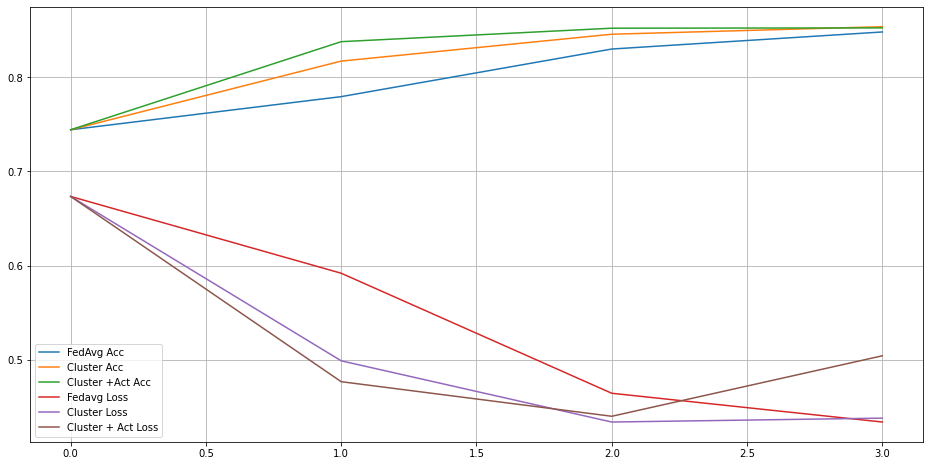

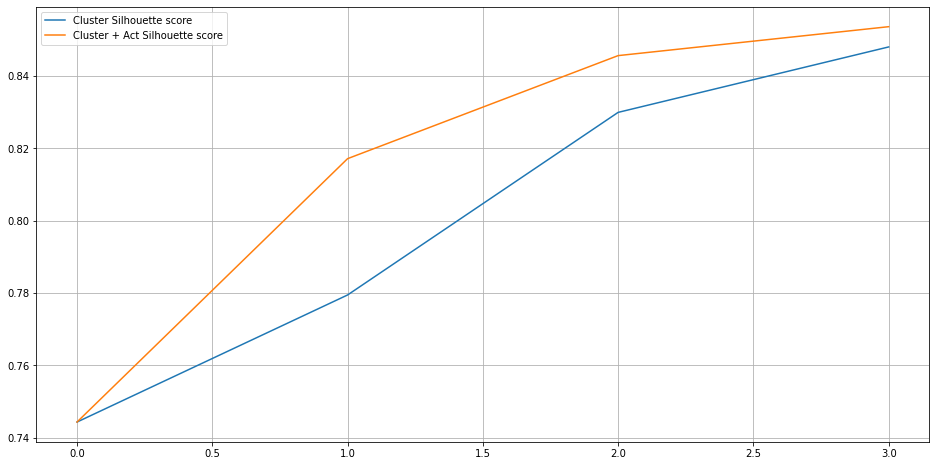

In [ ]:
average_acc_list, average_loss_list = [], []
average_acc_cluster_list, average_loss_cluster_list = [], []
average_acc_cluster_act_list, average_loss_cluster_act_list = [], []

ave_sil_score_cluster, ave_sil_score_cluster_act = [], []


for i in range(len(FedAvg_ACC)):
    average_acc_list.append(np.mean(FedAvg_ACC[i]))
    average_loss_list.append(np.mean(FedAvg_LOSS[i]))
    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    average_acc_cluster_act_list.append(np.mean(Clust_Act_ACC[i]))
    average_loss_cluster_act_list.append(np.mean(Clust_Act_LOSS[i]))
    
plt.figure(figsize=(16,8))
plt.plot(average_acc_list, label='FedAvg Acc')
plt.plot(average_acc_cluster_list, label='Cluster Acc')
plt.plot(average_acc_cluster_act_list, label='Cluster +Act Acc')

plt.plot(average_loss_list, label='Fedavg Loss')
plt.plot(average_loss_cluster_list, label='Cluster Loss')
plt.plot(average_loss_cluster_act_list, label='Cluster + Act Loss')

plt.grid(True)
plt.legend()
plt.show()


for i in range(len(Silhouette_sc_c_a)):
    ave_sil_score_cluster.append(np.mean(Silhouette_sc_c[i]))
    ave_sil_score_cluster_act.append(np.mean(Silhouette_sc_c_a[i]))

plt.figure(figsize=(16,8))
plt.plot(average_acc_list, label='Cluster Silhouette score')
plt.plot(average_acc_cluster_list, label='Cluster + Act Silhouette score')

plt.grid(True)
plt.legend()
plt.show()
